### References: http://www.scholarpedia.org/article/Echo_state_network, Hoerzer et al. 2014 Cerebral Cortex; Kumar et al. 2022 Cerebral Cortex

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# load eeg data and labels
trials = 100  # using 100 for testing. 
eeg_data = np.random.normal(size=[trials,73,1795]) # replace 1 with the actual data. i take it that the shape is 1000, 73, 1795
print(eeg_data.shape)

eeg_label = np.array([0,1,2,3,4]*int(trials//5))[:,None]  # replace with actual labels, shape should be 1000,1
print(eeg_label.shape)

(100, 73, 1795)
(100, 1)


In [5]:
# shuffle data
def shuffle_arrays(A, B, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    # Generate a random permutation of indices for the first dimension
    perm = np.random.permutation(A.shape[0])
    
    # Apply the permutation to shuffle A and B
    A_shuffled = A[perm, ...]
    B_shuffled = B[perm, ...]
    
    return A_shuffled, B_shuffled

eeg_shuff, label_shuff = shuffle_arrays(eeg_data, eeg_label, seed=42)

In [6]:
class ReservoirComputingNetwork:
    def __init__(self, input_size, reservoir_size, output_size, chaos=1.2, tau=10, dt=1, learning_rate=0.001):
        self.tau = tau  # time constant
        self.alpha = dt/self.tau
        self.nin = input_size
        self.nrnn = reservoir_size
        self.nout = output_size
        self.cp = [1,0.1]  #connection probability
        self.lr = learning_rate
        self.w_in_scale = 0.1
        
        # Initialize weights
        winconn = np.random.uniform(-1, 1, (self.nrnn, self.nin)) * self.w_in_scale  # uniform dist [-1,1]
        winprob = np.random.choice([0, 1], (self.nrnn, self.nin), p=[1 - self.cp[0], self.cp[0]])
        self.w_in = np.multiply(winconn, winprob) # cater to different input connection probabilities

        connex = np.random.normal(0, np.sqrt(1 / (self.cp[1] * self.nrnn)), size=(self.nrnn, self.nrnn))
        prob = np.random.choice([0, 1], (self.nrnn, self.nrnn), p=[1 - self.cp[1], self.cp[1]])
        w_rec = chaos * np.multiply(connex, prob)  # initialise random network with connection probability
        w_rec *= (np.eye(self.nrnn) == 0)  # remove self recurrence
        self.w_rec = w_rec

        self.w_fb = np.random.uniform(-1, 1, (self.nrnn, self.nout)) 
        
        self.w_out = np.random.rand(output_size, reservoir_size) * 1/reservoir_size

    def reset(self,trial):
        np.random.seed(trial)
        self.state = np.random.rand(self.nrnn)*0.1
        self.output = np.random.rand(self.nout)*0.1

    
    def run(self, input_vector):
        # Update reservoir state using leaky integrator rule
        I = np.dot(self.w_in, input_vector)
        h = np.dot(self.w_rec, self.state)
        fb = np.dot(self.w_fb, self.output)
        self.state = (1.0 - self.alpha) * self.state + self.alpha * np.tanh(I + h + fb)
        
        # Compute output
        self.output = np.dot(self.w_out, self.state)
        return self.output
    
    def learn(self, predicted_output,target_output):
        # Simple delta rule (Gradient descent on the output weights)
        # Run network to get current output
        self.error = target_output - predicted_output
        
        # Update the output weights using the delta rule
        self.w_out += self.lr * np.outer(self.error, self.state)
        return self.error

In [7]:
# modeltask setup
total_instruments = 5
trial_length = eeg_shuff.shape[2] # ms, change according to how long each trial was
dt = 1 # ms
total_trials = eeg_shuff.shape[0]
test_trials = [1,total_trials//2,total_trials]  # trials in which classifier is not updated

ninputs = num_eeg_channels = eeg_shuff.shape[1]
nrnn = 1024  # can make it bigger, but 1024 is the smallest for this model
noutputs = total_instruments
tau = 20  # between 10 to 100, larger allows the model to integrate information over longer time horizon
chaos = 1.5
lr = 0.001  # dont go higher than 0.01

reservoir = ReservoirComputingNetwork(input_size=ninputs, reservoir_size=nrnn, output_size=noutputs,chaos=chaos, tau=tau,learning_rate=lr)
init_wout = reservoir.w_out.copy()

KeyboardInterrupt: 

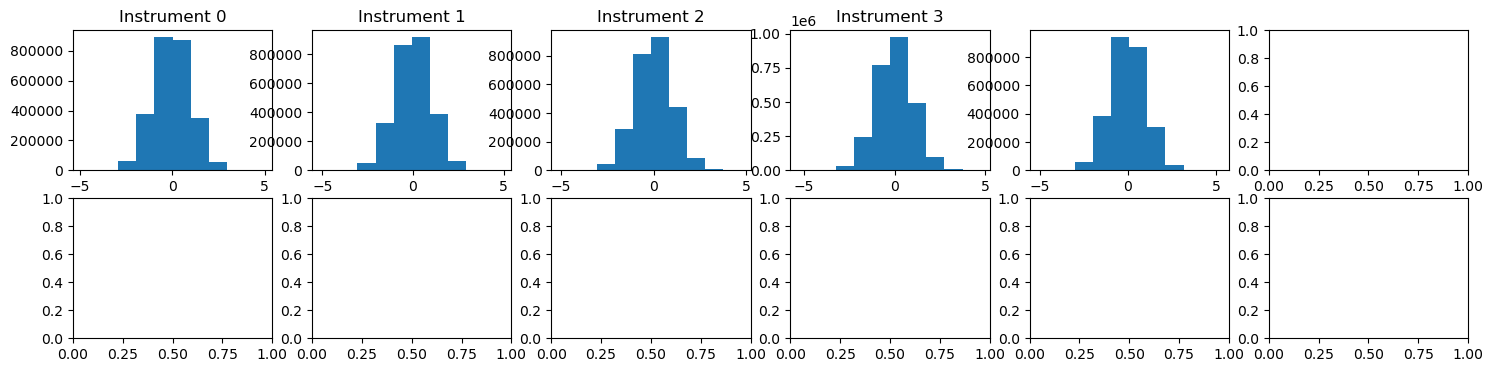

In [ ]:
# # plot difference in data distribution
# # ensure that different instruments elicit anti-correlated audio data, brain signals, EEG data

# eegs = np.zeros([total_instruments,  num_eeg_channels*trial_length*(total_trials//total_instruments)])
# res = np.zeros([total_instruments, trial_length*(total_trials//total_instruments), nrnn])


# f,ax = plt.subplots(2,6,figsize=(3*6,2*2))
# for instrument in range(total_instruments):

#     idx = (label_shuff == instrument)[:,0]
#     eegs[instrument] = eeg_shuff[idx].reshape(-1)


#     instrument_label = label_shuff[idx]

#     ax[0,instrument].hist(eegs[instrument])


#     x = eegs[instrument].reshape(-1, num_eeg_channels)
#     reservoir.reset(0)
#     for t in range(x.shape[0]):
#         _ = reservoir.run(x[t])
#         res[instrument, t] = reservoir.state

#     ax[0,instrument].set_title(f'Instrument {instrument}')

# corrs = np.zeros([total_instruments, total_instruments, 4])
# for d, data in enumerate([eegs, res]):
#     for i in range(total_instruments):
#         for j in range(total_instruments):
#             corrs[i,j,d] = np.corrcoef(data[i].reshape(-1), data[j].reshape(-1))[0,1]
#     im = ax[d,5].imshow(corrs[:,:,d])
#     plt.colorbar(im,ax=ax[d,5])

# ax[0,0].set_ylabel('EEG dist.')
# ax[1,0].set_ylabel('RNN dist.')

# f.tight_layout()

In [10]:
# sample code to load eeg_data and eeg_labels

record_output = np.zeros([total_trials, trial_length, noutputs])
record_error = np.zeros([total_trials, trial_length, noutputs])

for trial in range(total_trials):
    # insert eeg data here
    data = eeg_shuff[trial]
    instrument_class = label_shuff[trial]
    ground_truth = np.eye(total_instruments)[instrument_class]

    # initialize reservoir dynamics at the start at each run
    reservoir.reset(trial)
    for time in range(trial_length):
        x_eeg = data[:,time]

        # predict classifier output
        pred = reservoir.run(x_eeg)

        # online learning to classify , if trial is in test_trials, do not change classifier weights/learn
        if trial+1 not in test_trials:
            error = reservoir.learn(pred, ground_truth)

        record_output[trial, time] = pred
        record_error[trial, time] = ground_truth - pred

Test classication error Before Training: 0.11476323119777158, Chance is 0.2
Test classication error After Training: 0.0


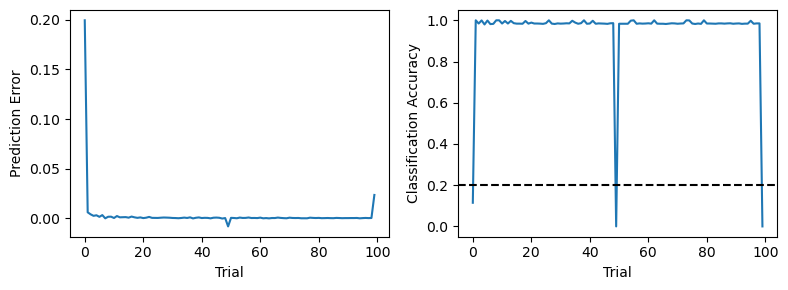

In [33]:
f,ax = plt.subplots(1,2,figsize=(8,3))
error = np.mean(np.mean(record_error,axis=1),axis=1)
ax[0].plot(error)
ax[0].set_xlabel('Trial')
ax[0].set_ylabel('Prediction Error')

accuracy = np.mean(label_shuff == np.argmax(record_output,axis=2),axis=1)
ax[1].plot(accuracy)
ax[1].set_xlabel('Trial')
ax[1].set_ylabel('Classification Accuracy')
ax[1].axhline(1/total_instruments,color='k',linestyle='--')

f.tight_layout()

before_test = accuracy[0]
after_test = accuracy[-1]
print(f'Test classication error Before Training: {before_test}, Chance is {1/total_instruments}')
print(f'Test classication error After Training: {after_test}')


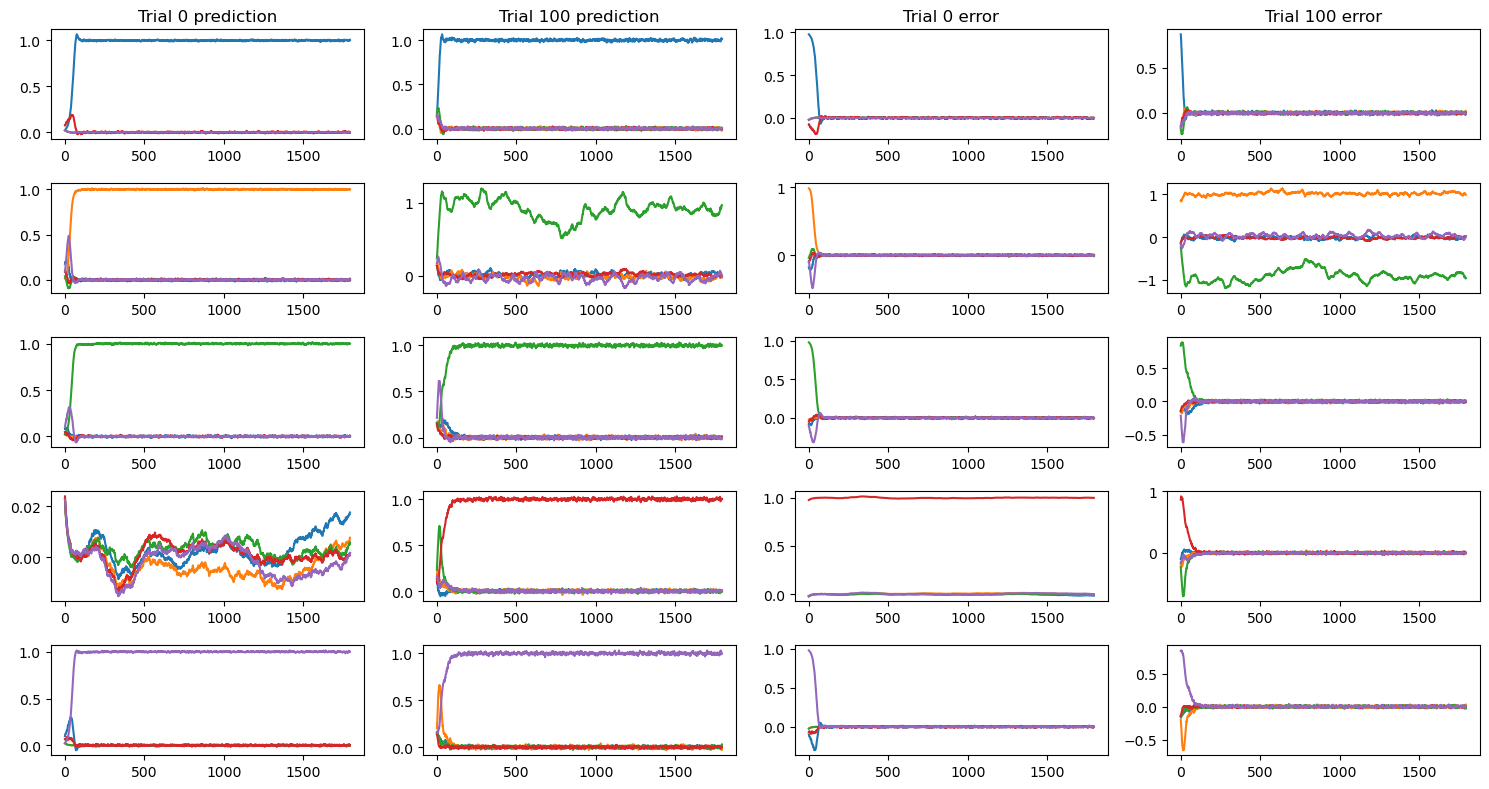

In [41]:
f,ax = plt.subplots(total_instruments,4,figsize=(3*total_instruments,2*4))

index = np.arange(total_trials)
for instrument in range(total_instruments):
    idx = index[label_shuff[:,0]== instrument]

    ax[instrument, 0].plot(record_output[idx[0]])

    ax[instrument, 1].plot(record_output[idx[-1]])

    ax[instrument, 2].plot(record_error[idx[0]])

    ax[instrument, 3].plot(record_error[idx[-1]])

ax[0,0].set_title('Trial 0 prediction')
ax[0,1].set_title(f'Trial {total_trials} prediction')

ax[0,2].set_title('Trial 0 error')
ax[0,3].set_title(f'Trial {total_trials} error')

f.tight_layout()